# FMQA - 16 Rings

## 16環改成更多環的注意事項
FoM不能再用讀取的了，要改成計算的方式。要改的地方用「~!@#$%^&*()_+」標註
Loss Convergence
- 產生all_configs去計算FoM的計算量會太大，調整all_configs要生成的數量
Problem Representation & Problem Representation (by FMQA)
- 無法再用Exact來驗證，改成用Random

## 改成script的注意事項
要複製的程式：Import, Define Class, Define Params & Path, Define Funcs, FMQA(不含Problem Representation)
Import
- random seed設為隨機

# Import

In [8]:
import os
import sys
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, special

# Setting Environment Variable (Has to be set before importing mxnet, or it will perform multiprocessing automatically but without any imrpoved efficiency)
os.environ['MXNET_CPU_WORKER_NTHREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

# Factorization Machine
import mxnet as mx
from mxnet import nd
from factorization_machine import FactorizationMachine as OriginalFactorizationMachine

# Fix the random seeds
# int(time.time())
random.seed(42)
np.random.seed(42)
mx.random.seed(42)

# QUBO Sampler
import dimod
import dwave.inspector
from dimod import ExactSolver
from dwave.samplers import RandomSampler, SimulatedAnnealingSampler, SteepestDescentSampler, TabuSampler
from dwave.system import DWaveSampler, DWaveCliqueSampler, EmbeddingComposite, FixedEmbeddingComposite

# Define Class

In [9]:
class FactorizationMachine(OriginalFactorizationMachine):

    def __call__(self, xs):
        """Override __call__ to handle numpy array input automatically."""
        if isinstance(xs, np.ndarray):
            xs = nd.array(xs)  # 自動轉換 numpy 陣列
        return super().__call__(xs)
    
    def loss(self, dataset):
        """
        計算loss
        - mean((ys - outputs)**2)
    
        參數
        - dataset: [xs, ys]
        """
        xs = nd.array(dataset[0])
        ys = nd.array(dataset[1])
        return nd.mean( ( ys - self(xs) ) ** 2 ).asscalar()

    def get_bhQ_scaled(self):
        """原始程式有做scaling"""
        # b: bias, h: linear, Q: quadratic (上三角部分)，皆為 numpy array
        b, h, Q = self.get_bhQ()  
        
        h_max = np.max(np.abs(h))
        Q_max = np.max(np.abs(Q))
        scaling_factor = max(h_max, Q_max)
        
        b /= scaling_factor
        h /= scaling_factor
        Q /= scaling_factor

        return b, h, Q

    def bqm(self):
        """從 model 得到 bqm"""
        b, h, Q = self.get_bhQ()
        # b, h, Q = self.get_bhQ_scaled()    # b: bias, h: linear, Q: quadratic (上三角部分)，皆為 numpy array

        return dimod.BinaryQuadraticModel(h, Q, b, dimod.BINARY)    # BQM(linear, quadratic, offset, vartype)

    def plot_Q_matrix(self, show_fig=False, path_fig="Q_matrix_heatmap.png", save_fig=True, path_data="Q_matrix.npy", save_data=True):
        """畫Q matrix的heatmap"""
        b, h, Q = self.get_bhQ()
        # b, h, Q = self.get_bhQ_scaled()    # bias, linear, qudratic(upper tri)
        Q = Q + Q.T
        np.fill_diagonal(Q, h)
        
        if save_data:
            np.save(path_data, Q)

        if show_fig or save_fig:
            max_abs_val = np.max(np.abs(Q))
            plt.figure()
            plt.imshow(Q, cmap="bwr", vmin=-max_abs_val, vmax=max_abs_val)
            plt.colorbar()
            plt.title("Q Matrix")

            if save_fig:
                plt.savefig(path_fig, bbox_inches='tight', transparent=True)    
            if show_fig:
                plt.show()
            else:
                plt.close()

    def save_model(self, path="model.params"):
        """儲存model參數、optimizer狀態"""
        mx.nd.waitall()
        self.save_parameters(path)
        
        if self.trainer is not None:
            self.trainer.save_states(path + ".trainer")

    @staticmethod
    def load_model(var_num, K, path="model.params"):
        """
        讀取並返回model參數、optimizer狀態

        參數
        - var_num : qubits數
        - K       : Factorization Machine的K
        """
        model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
        model.load_parameters(path, ctx=mx.cpu())

        # 需要先初始化 Trainer，然後才能載入 state
        model.trainer = mx.gluon.Trainer(model.collect_params(), "adam")

        try:
            model.trainer.load_states(path + ".trainer")
        except FileNotFoundError:
            print("沒有讀到optimizer的參數")

        return model

# Define Parameters & Path

In [11]:
## 設定參數

multiple = 8.0
resolution = 2_000
r_vec = np.linspace(0, multiple, resolution)    # 單位:波長
wavelength = 0.53
k = 2*np.pi/wavelength
NA = 0.95

init_dataset_size = 100
rings = 16
K = rings
dataset_split_ratio = 0.5    # 訓練集的占比
iteration = 15
num_reads = 2_000    # sampler的退火次數
top_energy = 100     # 從num_reads個energies中，取前top_energy小的energies
top_fom = 20         # 從top_energy個energies中，取前top_fom小的foms
num_epoch = 1_000    # FM每個iter訓練的epochs數

target_method = "amp_step"
target_max_mul = 8.0
target_step_point_mul = 0.2
target_step_left_val = 1.0
target = [target_method, target_max_mul, target_step_point_mul, target_step_left_val]
target_str = "_".join(map(str, target))

sampler_type = "SA_Tabu"    # 有Exact, Random, SA, SD, Tabu, SA_SD, SA_Tabu, QA_Auto, QA_Clique
qpu_solver = {"name": "Advantage2_system1.1"}

In [12]:
## file name

def create_init_path(base_folder_name):
    """建立這次模擬的資料夾"""
    os.makedirs(base_folder_name, exist_ok=True)

    # 找出資料夾的最大值（如果沒有就是None）
    max_num = None
    for folder in os.listdir(base_folder_name):
        folder_name = os.path.join(base_folder_name, folder)
        if os.path.isdir(folder_name) and folder.isdigit():
            folder_number = int(folder)
            if (max_num is None) or (folder_number > max_num):
                max_num = folder_number

    # 設定program_id
    if max_num is None:
        program_id = str(1)
    else:
        program_id = str(max_num + 1)

    # 建立program_id對應的資料夾
    base_path = os.path.join(base_folder_name, program_id)
    os.makedirs(base_path, exist_ok=True)
    
    return program_id

# 設定基礎路徑
base_folder_name = "saved_files"
program_id = create_init_path(base_folder_name)
base_path = os.path.join(base_folder_name, program_id)
print(program_id)

# 記錄設定參數檔案的路徑
params_file_name = "params.txt"
params_path = os.path.join(base_path, params_file_name)

# field table (保存在與程式檔同層的資料夾底下的field_tables資料夾，這樣其他程式也可以使用)
field_table_folder_name = "field_tables"
field_table_file_name = f"field_table_{rings}_{multiple}_{resolution}_{wavelength}_{NA}.npy"    # 檔名應包含: rings, multiple, resolution, wavelength, NA
field_table_path = os.path.join(field_table_folder_name, field_table_file_name)

# configs & foms的base path（保存在與程式檔同層的資料夾底下的configs_foms資料夾，這樣其他程式也可以使用）
configs_foms_folder_name = "configs_foms"
os.makedirs(configs_foms_folder_name, exist_ok=True)

# 生成所有組態 & 計算所有對應的FoM的檔名（16環以內可以生成所有可能的組態，16環以上計算量會太大，自己調整生成的數量，但變數名稱不變）
all_configs_file_name = f"all_configs_{rings}_{multiple}_{resolution}_{wavelength}_{NA}.npy"
all_foms_file_name = f"all_foms_{target_str}_{rings}_{multiple}_{resolution}_{wavelength}_{NA}.npy"
all_configs_path = os.path.join(configs_foms_folder_name, all_configs_file_name)
all_foms_path = os.path.join(configs_foms_folder_name, all_foms_file_name)

# 初始生成組態 & 對應的FoM的檔名
init_configs_file_name = f"init_configs_{init_dataset_size}_{rings}_{multiple}_{resolution}_{wavelength}_{NA}.npy"
init_foms_file_name = f"init_foms_{init_dataset_size}_{target_str}_{rings}_{multiple}_{resolution}_{wavelength}_{NA}.npy"
init_configs_path = os.path.join(configs_foms_folder_name, init_configs_file_name)
init_foms_path = os.path.join(configs_foms_folder_name, init_foms_file_name)

# FoM分布 <- 只有16環ipynb有
fom_dist_file_name = "FoM Distribution.png"
fom_dist_path = os.path.join(base_path, fom_dist_file_name)

# dynamic FM的model資料夾、fig
dynamic_FM_model_folder_name = os.path.join(base_path, "dynamic_FM_model")
dynamic_FM_fig_file_name = "Loss-Epochs Curve.png"
dynamic_FM_fig_path = os.path.join(dynamic_FM_model_folder_name, dynamic_FM_fig_file_name)

# 訓練好的model他的energy跟FoM的圖 <- 只有16/64環的ipynb有
FM_file_name = "FM.png"
FM_path = os.path.join(base_path, FM_file_name)

# 跑完FMQA得到的configs, foms（存數據、存圖）
configs_arr_file_name = "configs.npy"
foms_arr_file_name = "foms.npy"
foms_fig_file_name = "foms.png"
foms_fig_best_record_file_name = "foms - best record.png"
configs_arr_path = os.path.join(base_path, configs_arr_file_name)
foms_arr_path = os.path.join(base_path, foms_arr_file_name)
foms_fig_path = os.path.join(base_path, foms_fig_file_name)
foms_fig_best_record_path = os.path.join(base_path, foms_fig_best_record_file_name)

# FMQA每次新增的筆數(actual_new_data)
actual_new_data_file_name = "actual_new_data.npy"
actual_new_data_path = os.path.join(base_path, actual_new_data_file_name)

# fmqa每次iter的model跟model的Q_matrix（每個iter都要調整path）
iter_model_Q_folder_name = "model&Q"
iter_model_Q_path = os.path.join(base_path, iter_model_Q_folder_name)
os.makedirs(iter_model_Q_path) #, exist_ok=True)    不應該有資料夾已經存在
iter_model_file_name = "model.params"
iter_Q_arr_file_name = "Q.npy"
iter_Q_fig_file_name = "Q.png"

316


In [13]:
# 將變數寫入文字檔
variables = {
    "multiple": multiple,
    "resolution": resolution,
    "wavelength": wavelength,
    "NA": NA,
    "init_dataset_size": init_dataset_size,
    "rings": rings,
    "K": K,
    "dataset_split_ratio": dataset_split_ratio,
    "iteration": iteration,
    "num_reads": num_reads,
    "top_energy": top_energy,
    "top_fom": top_fom,
    "num_epoch": num_epoch,
    "target": target,
    "sampler_type": sampler_type,
    "qpu_solver": qpu_solver,
}

with open(params_path, "w", encoding="utf-8") as f:
    for key, value in variables.items():
        f.write(f"{key} = {value}\n")

# Define Functions

In [14]:
def generate_unique_binary_array(init_dataset_size, rings):
    max_unique = 2 ** rings
    
    if init_dataset_size > max_unique:
        raise ValueError(f"Cannot generate {init_dataset_size} unique rows with only {rings} bits. Maximum is {max_unique}.")
    
    def unique_binary_generator():
        seen = set()
        while len(seen) < init_dataset_size:
            new_row = tuple(np.random.randint(0, 2, size=rings))
            if new_row not in seen:
                seen.add(new_row)
                yield np.array(new_row, dtype=np.int8)
    
    # Use a generator to yield rows one at a time
    result = np.array(list(unique_binary_generator()))
    
    # Shuffle the rows
    np.random.shuffle(result)
    
    return result

In [15]:
def choose_sampler(sampler_type = "SA"):
    """
    定義要使用的sampler
    全域變數: qpu_solver
    """
    if sampler_type == "Exact":
        if rings <= 16:
            sampler = ExactSolver()
        else:
            print("環數太多，不能使用Exact Solver")
            sys.exit(1)
    elif sampler_type == "Random":
        sampler = RandomSampler()
    elif sampler_type == "SA":
        sampler = SimulatedAnnealingSampler()
    elif sampler_type == "SD":
        sampler = SteepestDescentSampler()
    elif sampler_type == "Tabu":
        sampler = TabuSampler()
    elif sampler_type == "QA_Auto":
        sampler = EmbeddingComposite(DWaveSampler(qpu_solver))
    elif sampler_type == "QA_Clique":
        sampler = DWaveCliqueSampler(qpu_solver)
    else:
        print("沒有這個QUBO sampler")
        sys.exit(1)
    
    return sampler

def sampling(sampler_type, bqm, num_reads=None):
    """
    開始annealing/sampling
    全域變數: 無
    """

    sampler_types = ["Exact", "Random", "SA", "SD", "Tabu", "QA_Auto", "QA_Clique"]
    if sampler_type in sampler_types:
        sampler = choose_sampler(sampler_type)
    
    # 單次模擬
    if sampler_type == "Exact":
        sampleset = sampler.sample(bqm)
    elif sampler_type == "Random":
        sampleset = sampler.sample(bqm, num_reads=num_reads)
    elif sampler_type == "SA":
        sampleset = sampler.sample(bqm, num_reads=num_reads, num_sweeps=1_000)
    elif sampler_type == "SD":
        sampleset = sampler.sample(bqm, num_reads=num_reads)
    elif sampler_type == "Tabu":
        sampleset = sampler.sample(bqm, num_reads=num_reads)
    elif sampler_type == "QA_Auto":
        sampleset = sampler.sample(bqm, num_reads=num_reads, annealing_time=20)
    elif sampler_type == "QA_Clique":
        sampleset = sampler.sample(bqm, num_reads=num_reads, annealing_time=20)

    # 多次模擬
    elif sampler_type == "SA_SD":
        sampler = choose_sampler("SA")
        sampleset = sampler.sample(bqm, num_reads=num_reads, num_sweeps=1_000)
        sampler = choose_sampler("SD")
        sampleset = sampler.sample(bqm, num_reads=num_reads, initial_states=sampleset)
    elif sampler_type == "SA_Tabu":
        sampler = choose_sampler("SA")
        sampleset = sampler.sample(bqm, num_reads=num_reads, num_sweeps=1_000)
        sampler = choose_sampler("Tabu")
        sampleset = sampler.sample(bqm, num_reads=num_reads, initial_states=sampleset)

    # 
    else:
        print("沒有這個sampler")
        sys.exit(1)
    
    return sampleset

In [16]:
def mul2idx(mul):
    """全域變數: resolution, multiple"""
    return int( mul * resolution / multiple )

def idx2mul(idx):
    """全域變數: resolution, multiple"""
    return idx * multiple / resolution

## Field & Intensity

In [17]:
def generate_field_table(rings, path=None):
    """
    全域變數: k, r_vec, NA, wavelength
    """

    N = rings
    
    def integrand(theta, k, r):
        """
        theta : 積分變數
        """
        return np.sqrt(np.cos(theta)) * special.j0(k*r*np.sin(theta)) * np.sin(theta)
        
    sine_ls = np.linspace(0, NA, N+1)    # n個環需要有n+1個點
    theta_ls = np.arcsin(sine_ls)
    
    field_table = np.zeros(shape=(r_vec.shape[0], N), dtype=np.float64)    # 因為field計算出來是純需數，所以這邊直接使用實數儲存
    for r_idx in range(r_vec.shape[0]):
        for n in range(1, N+1):
            integral, err = integrate.quad(integrand, theta_ls[n-1], theta_ls[n], args=(k, r_vec[r_idx]*wavelength))
            field_table[r_idx, n-1] = 2*np.pi/wavelength * integral

    if path:
        np.save(path, field_table)

    return field_table

In [18]:
def calc_field(config, scale=False):
    """全域變數: field_table_path, r_vec"""
    config_processed = np.array([-1 if element==0 else element for element in config], dtype=np.int8)
    N = rings = config_processed.shape[0]

    # Build the field table
    if os.path.exists(field_table_path):
        field_table = np.load(field_table_path)
    else:
        field_table = generate_field_table(rings=rings, path=field_table_path)

    # Calculate the field
    field_vec = np.zeros(shape=r_vec.shape[0], dtype=np.float64)
    for r_idx in range(r_vec.shape[0]):
        for n in range(1, N+1):
            field_vec[r_idx] += config_processed[n-1] * field_table[r_idx, n-1]

    # Scale the field
    if scale:
        eps = 1e-20
        field_vec /= field_vec[0] + eps

    return field_vec

In [19]:
def calc_intensity(config, scale=False):
    """
    全域變數: r_vec
    返回值：first_zero_point == -1 代表沒有零點
    """
    # Calculate the field and intensity
    field_vec = calc_field(config, scale=False)
    intensity_vec = np.abs(field_vec) ** 2
    
    # Scale the intensity
    if scale:
        eps = 1e-20
        intensity_vec /= intensity_vec[0] + eps

    # Calculate the index and multiple of the first zero point
    first_zero_point_idx = -1
    for r_idx in range(1, intensity_vec.shape[0]-1):
        if (intensity_vec[r_idx-1] > intensity_vec[r_idx]) and (intensity_vec[r_idx+1] > intensity_vec[r_idx]) and (intensity_vec[r_idx] < 0.1):
            first_zero_point_idx = r_idx
            break
    if first_zero_point_idx > 0:
        first_zero_point_mul = idx2mul(first_zero_point_idx)
    else:
        first_zero_point_mul = -1

    return intensity_vec, first_zero_point_idx, first_zero_point_mul

## FoM

In [20]:
def step_func(max_mul, step_point_mul, step_left_val):
    max_idx = mul2idx(max_mul)
    step_point_idx = mul2idx(step_point_mul)
    
    step_vec = np.zeros(shape=(max_idx,), dtype=np.float64)
    step_vec[:step_point_idx] = float(step_left_val)
    step_vec[step_point_idx:] = 0.0

    return step_vec

In [21]:
def calc_fom(config, target):
    """
    target_method: amp_step, intensity_step(squared), intensity_step(no_squared), intensity_ratio, intensity_minus, intensity_minus
    全域變數: r_vec
    """
    target_method = target[0]
    
    if (target_method == "amp_step"):
        target_max_mul = target[1]
        target_step_point_mul = target[2]
        target_step_left_val = target[3]

        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        r_target_vec = r_vec[:target_max_idx]
        
        # Calculate the field
        field_vec = calc_field(config=config, scale=False)    # scale的話就不是quadratic了
        field_vec = field_vec[:target_max_idx]
        
        # Generate the step vec
        step_vec = step_func(target_max_mul, target_step_point_mul, target_step_left_val)
        
        # Calculate the figure of merit
        """FOM = ∫dr|A-At|^2"""
        diff = np.abs(field_vec - step_vec)
        fom = integrate.trapezoid(diff ** 2, r_target_vec)

    elif (target_method == "intensity_step(squared)"):
        target_max_mul = target[1]
        target_step_point_mul = target[2]
        target_step_left_val = target[3]
        
        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        r_target_vec = r_vec[:target_max_idx]
        
        # Calculate the intensity
        intensity_vec, _, _ = calc_intensity(config=config, scale=False)
        intensity_vec = intensity_vec[:target_max_idx]
        
        # Generate the step vec
        step_vec = step_func(target_max_mul, target_step_point_mul, target_step_left_val)
        
        # Calculate the figure of merit
        """FOM = ∫dr|I-It|^2"""
        diff = np.abs(intensity_vec - step_vec)
        fom = integrate.trapezoid(diff ** 2, r_target_vec)

    elif (target_method == "intensity_step(no_squared)"):
        target_max_mul = target[1]
        target_step_point_mul = target[2]
        target_step_left_val = target[3]
        
        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        r_target_vec = r_vec[:target_max_idx]
        
        # Calculate the intensity
        intensity_vec, _, _ = calc_intensity(config=config, scale=False)
        intensity_vec = intensity_vec[:target_max_idx]
        
        # Generate the step vec
        step_vec = step_func(target_max_mul, target_step_point_mul, target_step_left_val)
        
        # Calculate the figure of merit
        """FOM = ∫dr|I-It|"""
        diff = np.abs(intensity_vec - step_vec)
        fom = integrate.trapezoid(diff, r_target_vec)

    elif (target_method == "intensity_ratio"):
        target_max_mul = target[1]
        target_step_point_mul = target[2]

        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        target_step_point_idx = mul2idx(target_step_point_mul)
        r_target_vec = r_vec[:target_max_idx]
        
        # Calculate the intensity
        intensity_vec, _, _ = calc_intensity(config=config, scale=False)
        intensity_vec = intensity_vec[:target_max_idx]

        # Calculate the figure of merit
        """FOM = -(∫_{0}^{step_point} I dr - ∫_{step_point}^{target_max} I dr) / ∫_{0}^{target_max} I dr"""
        part_1 = integrate.trapezoid(intensity_vec[:target_step_point_idx], r_target_vec[:target_step_point_idx])
        part_2 = integrate.trapezoid(intensity_vec[target_step_point_idx:], r_target_vec[target_step_point_idx:])
        part_3 = integrate.trapezoid(intensity_vec, r_target_vec)
        fom = -(part_1 - part_2) / part_3

    elif (target_method == "intensity_minus"):
        target_max_mul = target[1]
        target_step_point_mul = target[2]

        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        target_step_point_idx = mul2idx(target_step_point_mul)
        r_target_vec = r_vec[:target_max_idx]
        
        # Calculate the intensity
        intensity_vec, _, _ = calc_intensity(config=config, scale=False)
        intensity_vec = intensity_vec[:target_max_idx]

        # Calculate the figure of merit
        """FOM = -(∫_{0}^{step_point} I dr - ∫_{step_point}^{target_max} I dr)"""
        part_1 = integrate.trapezoid(intensity_vec[:target_step_point_idx], r_target_vec[:target_step_point_idx])
        part_2 = integrate.trapezoid(intensity_vec[target_step_point_idx:], r_target_vec[target_step_point_idx:])
        fom = -(part_1 - part_2)

    elif (target_method == "intensity_first_zero"):
        target_max_mul = target[1]
        target_thresh = target[2]
        target_beta = target[3]

        # Generate the r_target_vec
        target_max_idx = mul2idx(target_max_mul)
        r_target_vec = r_vec[:target_max_idx]

        # Calculate the intensity & first zero point (need scaling)
        intensity_vec, first_zero_point_idx, first_zero_point_mul = calc_intensity(config=config, scale=True)
        intensity_vec = intensity_vec[:target_max_idx]

        # Calculate the figure of merit
        """
        FOM = 第一零點離原點的距離 + beta * 第一零點後到target_max_multiple間，超過target threshold的數值總和 / 
                                          第一零點後到target_max_multiple間，全部target threshold的數值總和
        """
        if (first_zero_point_idx <= 0) or (first_zero_point_idx >= target_max_idx):
            first_zero_point_mul = target_max_mul
            first_zero_point_idx = target_max_idx
            numerator   = 0
            denominator = 1
        else:
            mask = intensity_vec[first_zero_point_idx+1:] > target_thresh    # 第一零點之後，有哪些點的intensity超過target_threshold -> 生成一個boolean list
            numerator   = np.sum(intensity_vec[first_zero_point_idx+1:][mask] - target_thresh)
            denominator = np.sum(intensity_vec[first_zero_point_idx+1:])
        fom = first_zero_point_mul + target_beta * numerator / denominator

    # elif (target_method == "stephtan"):
        
    
    return fom

# Loss Convergence

In [22]:
# Generate all the configs & calculate all the FoM
start_time = time.time()
if not os.path.exists(all_configs_path):
    all_configs = generate_unique_binary_array(init_dataset_size=2**rings, rings=rings)    # 生成所有組態
    np.save(all_configs_path, all_configs)
else:
    all_configs = np.load(all_configs_path)
if not os.path.exists(all_foms_path):
    all_foms = np.array([calc_fom(config, target) for config in all_configs])
    np.save(all_foms_path, all_foms)
else:
    all_foms = np.load(all_foms_path)
end_time = time.time()
print(f"計算所有組態花了: {end_time - start_time} 秒")

# Split to the training set and the testing set
split_idx = int( all_foms.shape[0] * dataset_split_ratio )
all_configs_train, all_configs_test = all_configs[:split_idx], all_configs[split_idx:]
all_foms_train, all_foms_test       = all_foms[:split_idx], all_foms[split_idx:]
training_set = [all_configs_train, all_foms_train]
testing_set  = [all_configs_test, all_foms_test]

# Print the smallest FOM
if training_set[0].shape[0]:
    print(f"Smallest FOM in the training set: {np.min(training_set[1])}")
if testing_set[0].shape[0]:
    print(f"Smallest FOM in the testing set:  {np.min(testing_set[1])}")

計算所有組態花了: 1090.0495965480804 秒
Smallest FOM in the training set: 0.1741861879429386
Smallest FOM in the testing set:  0.1573540460362933


In [24]:
print(np.min(all_foms))
print(np.max(all_foms))

0.1573540460362933
14.358226681517241


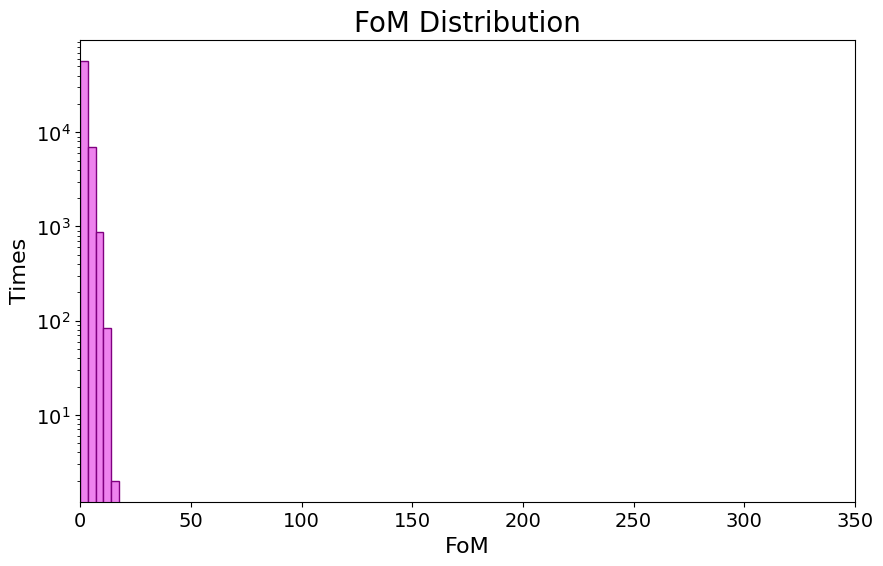

最小的FOM是: 0.1573540460362933


In [25]:
## 畫FoM分佈

# 設定參數
# value_range = (np.min(all_foms), np.max(all_foms))    # 觀察foms的範圍
value_range = (0, 350)
num_bins = 100  # 分成 100 個 bins
xtick_step = 50  # xticks 每隔 0.1 顯示一個值
if ((value_range[1]-value_range[0]) / xtick_step) > 50:
    print("太多個xticks")
    sys.exit(1)

# 繪製直方圖
plt.figure(figsize=(10,6))
plt.hist(all_foms, bins=num_bins, range=value_range, color="violet", edgecolor='purple')

# 設定刻度
plt.xticks(np.arange(value_range[0], value_range[1] + xtick_step, xtick_step), fontsize=14)
# plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 
plt.title('FoM Distribution', fontsize=20)
plt.xlabel('FoM', fontsize=16)
plt.ylabel('Times', fontsize=16)
plt.yscale("log")
plt.xlim(value_range)

#
plt.savefig(fom_dist_path, bbox_inches='tight', transparent=True)
plt.show()

print(f"最小的FOM是: {np.min(all_foms)}")

In [26]:
def dynamic_FM(dynamic_retrain, var_num, K, training_set, testing_set, show=False, model_folder=None, fig_path=None):
    """
    Purpose: Return the model with the least testing loss
    
    Plot
    - x axis : epochs number
    - y axis : loss

    Parameters
    - dynamic_retrain : 
    - var_num         : qubits數
    - K               : factorization machine的K
    - training_set    : [xs_train, ys_train]
    - testing_set     : [xs_test, ys_test]
    - show            : 
    """
    
    # 預處理
    if not testing_set[0].shape[0]:
        print("dynamic_FM: testing_set筆數為0，不能用dynamic model")
        sys.exit(1)
    
    xs_train = training_set[0]
    ys_train = training_set[1]
    xs_test  = testing_set[0]
    ys_test  = testing_set[1]
    
    # 存放losses的容器
    training_losses = list()
    testing_losses  = list()

    # 暫存model的資料夾
    # folder_name = "model_temp"
    folder_name = model_folder
    os.makedirs(folder_name, exist_ok=True)
    
    # 設定best model的路徑
    file_name = f"model_epochs_best.params"
    path = os.path.join(folder_name, file_name)
    
    # 要測試的epochs（這邊規定第一筆一定要是0，這樣寫起來比較方便）
    epochs_vec = [0,
                  1, 2, 3, 4, 5, 6, 7, 8, 9,
                  10, 20, 30, 40, 50, 60, 70, 80, 90,
                  100, 200, 300, 400, 500, 600, 700, 800, 900,
                  1_000, 2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000,
                  10_000,]# 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000,
                  # 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, 900_000,
                  # 1_000_000]
    if epochs_vec[0] != 0:
        print("epochs_vec的第一個元素不是0")
        sys.exit(1)

    # 開始找這次的best model
    for i in range(len(epochs_vec)):
        
        print(f"{epochs_vec[i]}個epochs")

        if 0 == i:    # 就是0==epochs，載入之前的best model，或是初始化model
            if (os.path.exists(path)) and (not dynamic_retrain):
                model = FactorizationMachine.load_model(var_num, K, path=path)
            else:
                model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
                model.init_params(initializer=mx.init.Normal())
        else:    # 訓練model
            epochs = epochs_vec[i] - epochs_vec[i-1]
            model.train(xs_train, ys_train, num_epoch=epochs, learning_rate=1.0e-2)

        # 存model
        file_name = f"model_epochs_{epochs_vec[i]}.params"
        path = os.path.join(folder_name, file_name)
        model.save_model(path=path)

        # 計算loss
        training_loss = model.loss( training_set )
        testing_loss  = model.loss( testing_set )
        training_losses.append( training_loss )
        testing_losses.append( testing_loss )

    # 轉為numpy array方便處理
    training_losses = np.array(training_losses, dtype=np.float64)
    testing_losses = np.array(testing_losses, dtype=np.float64)
    
    # 找出最好的epochs
    # valid_epochs_vec = training_losses <= testing_losses
    # if valid_epochs_vec.any():
    #     epochs_idx = np.where( testing_losses == np.min(testing_losses[valid_epochs_vec]) )[0][0]
    #     best_epochs = epochs_vec[epochs_idx]
    # else:
    #     print("所有testing set都比training set還要好，不合理 -> 應該是數據還不夠多")
    #     best_epochs = 0
    epochs_idx = np.argmin(testing_losses)
    best_epochs = epochs_vec[epochs_idx]

    # 讀取最好的epochs model
    file_name = f"model_epochs_{best_epochs}.params"
    path      = os.path.join(folder_name, file_name)
    model     = FactorizationMachine.load_model(var_num, K, path=path)
    
    # 把這次的最好的epcohs model存起來（如果每次都要重頭開始重新訓練就不用存了）
    if not dynamic_retrain:
        path = os.path.join(folder_name, f"model_epochs_best.params")
        model.save_model(path=path)
    
    # 畫圖
    if show:
        plt.plot(epochs_vec, training_losses, label="training_loss", color="red")
        plt.plot(epochs_vec, testing_losses, label="testing_loss", color="violet")
        plt.xscale("log")
        plt.xlim(left=epochs_vec[1])    # 這裡就不從epochs=0開始畫了，因為log scale畫不出x=0的部分
        plt.ylim(bottom=0)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss-Epochs Curve")
        plt.legend(loc="upper left", facecolor='none')
        plt.savefig(fig_path, bbox_inches='tight', transparent=True)
        plt.show()

    # 顯示best epochs的資訊
    print(f"best epochs: {best_epochs}")
    print(f"best epochs的training loss是: {training_losses[epochs_vec.index(best_epochs)]}")
        
    return model

0個epochs
1個epochs
2個epochs
3個epochs
4個epochs
5個epochs
6個epochs
7個epochs
8個epochs
9個epochs
10個epochs
20個epochs
30個epochs
40個epochs
50個epochs
60個epochs
70個epochs
80個epochs
90個epochs
100個epochs
200個epochs
300個epochs
400個epochs
500個epochs
600個epochs
700個epochs
800個epochs
900個epochs
1000個epochs
2000個epochs
3000個epochs
4000個epochs
5000個epochs
6000個epochs
7000個epochs
8000個epochs
9000個epochs
10000個epochs


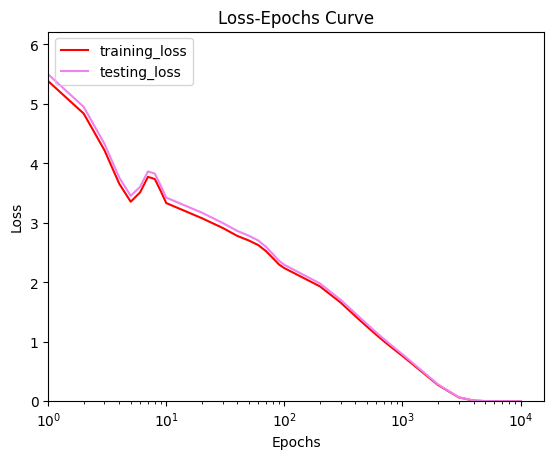

best epochs: 9000
best epochs的training loss是: 5.973762995381549e-07


In [27]:
model = dynamic_FM(dynamic_retrain=True, var_num=rings, K=rings, training_set=training_set, testing_set=testing_set, show=True, model_folder=dynamic_FM_model_folder_name, fig_path=dynamic_FM_fig_path)

# Problem Representation
驗證FM能不能夠代表原始的物理問題
- FM將權重作為Q matrix丟到sampler（要用ExactSampler或是RandomSampler取決於rings數），如果anneal出來的energy跟對應的FoM的「低谷」一致，FM就能夠代表原始的物理問題

In [28]:
sampleset = sampling(sampler_type="Exact", bqm=model.bqm(), num_reads=None)

# 取得所有組態、能量、FOMs
start_time = time.time()
sample_configs  = sampleset.record["sample"]
sample_energies = sampleset.record["energy"]
print("開始計算")
# sample_foms     = np.array([calc_fom(config, target) for config in sample_configs])
#############################~!@#$%^&*()_+############################################
sample_foms = []
for i in range(len(sample_energies)):
    sample_config = sample_configs[i]
    query_idx = np.where((all_configs == sample_config).all(axis=1))[0][0]
    if query_idx.size:
        sample_foms.append(all_foms[query_idx])
    else:
        print("No query data")
        sys.exit(1)
sample_foms = np.array(sample_foms, dtype=np.float64)
#####################################################################################
end_time = time.time()
print(f"計算所有FOMs花了: {end_time - start_time} 秒")

# 讓energy由小排到大，其他變數跟著動
sorted_indices  = np.argsort(sample_energies)
sample_configs  = sample_configs[sorted_indices]
sample_energies = sample_energies[sorted_indices]
sample_foms     = sample_foms[sorted_indices]

開始計算
計算所有FOMs花了: 148.0233609676361 秒


最小FoM的Index: 0


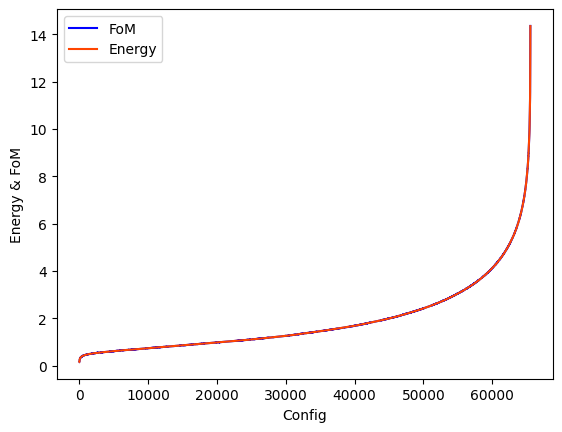

In [29]:
plt.plot(sample_foms, label="FoM", color="blue")
plt.plot(sample_energies, label="Energy", color="orangered")
plt.legend(facecolor='none')
# plt.xlim(0)
# plt.ylim(-2)
# plt.xlim(0, 100)
# plt.ylim(-0.675, -0.575)
plt.xlabel("Config")
plt.ylabel("Energy & FoM")
plt.savefig(FM_path, bbox_inches='tight', transparent=True)
print(f"最小FoM的Index: {np.argmin(sample_foms)}")

# FMQA

In [30]:
# 初始數據
if os.path.exists(init_configs_path):
    configs = np.load(init_configs_path)
else:
    configs = generate_unique_binary_array(init_dataset_size=init_dataset_size, rings=rings)
    np.save(init_configs_path, configs)

if os.path.exists(init_foms_path):
    foms = np.load(init_foms_path)
else:
    # foms = np.array([calc_fom(config, target) for config in configs])
    #############################~!@#$%^&*()_+#######################################
    foms = []
    for i in range(len(configs)):
        config = configs[i]
        query_idx = np.where((all_configs == config).all(axis=1))[0][0]
        if query_idx.size:
            foms.append(all_foms[query_idx])
        else:
            print("No query data")
            sys.exit(1)
    foms = np.array(foms, dtype=np.float64)
    #####################################################################################
    np.save(init_foms_path, foms)

In [31]:
# 初始化FM
model = FactorizationMachine(input_size=rings, factorization_size=K, act="identity")
model.init_params(initializer=mx.init.Normal())

第1次iteration


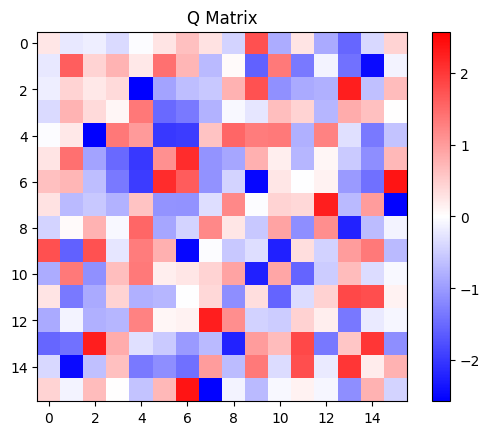

這個iter最小的FOM: 0.6344463150631328
第2次iteration


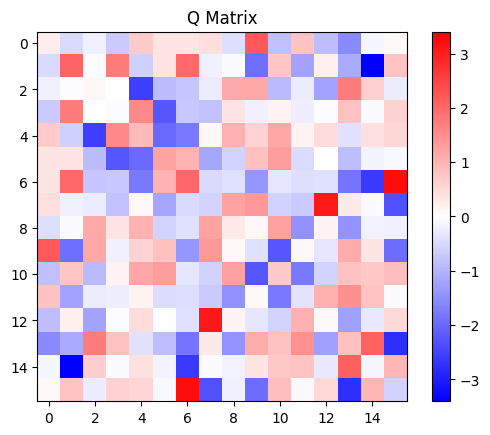

這個iter最小的FOM: 0.6781214900207616
第3次iteration


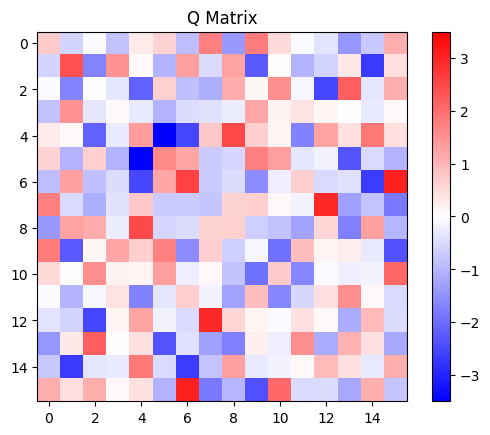

這個iter最小的FOM: 0.5239660062533993
第4次iteration


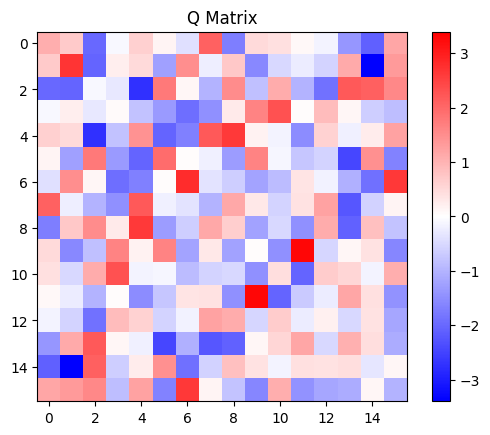

這個iter最小的FOM: 0.3695330718195605
第5次iteration


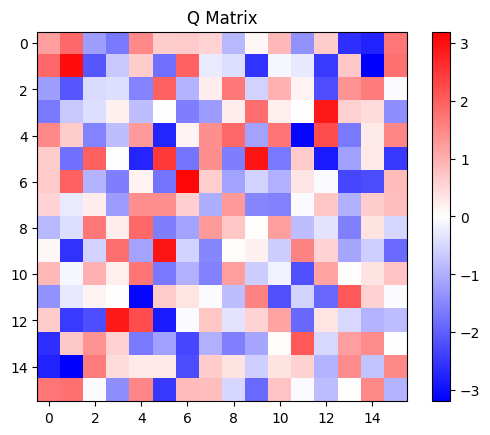

這個iter最小的FOM: 1.6336466792686173
第6次iteration


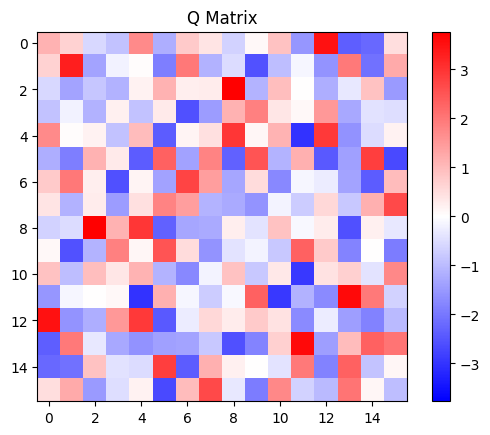

這個iter最小的FOM: 1.639684125390345
第7次iteration


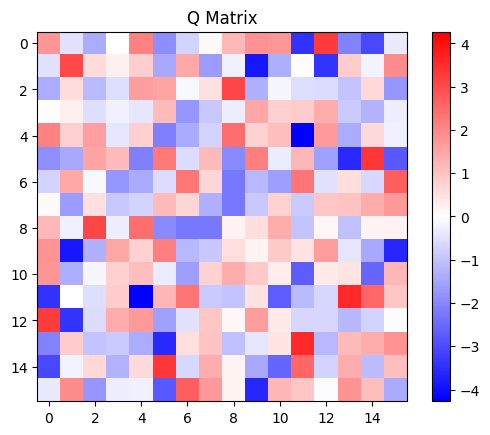

這個iter最小的FOM: 1.4324067127904117
第8次iteration


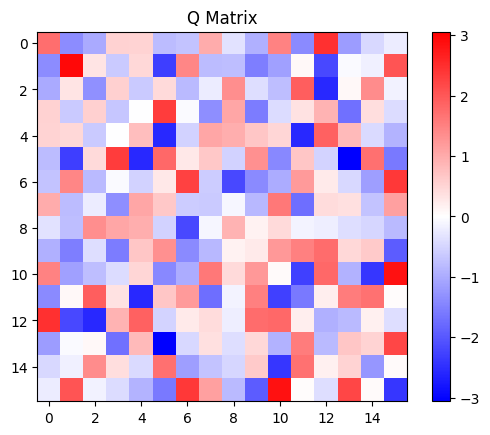

這個iter最小的FOM: 1.636383939710184
第9次iteration


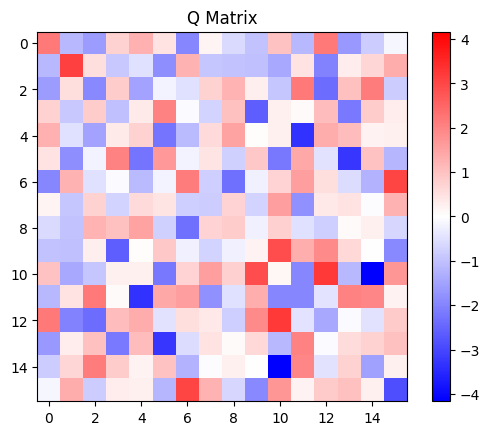

這個iter最小的FOM: 0.8612616783048148
第10次iteration


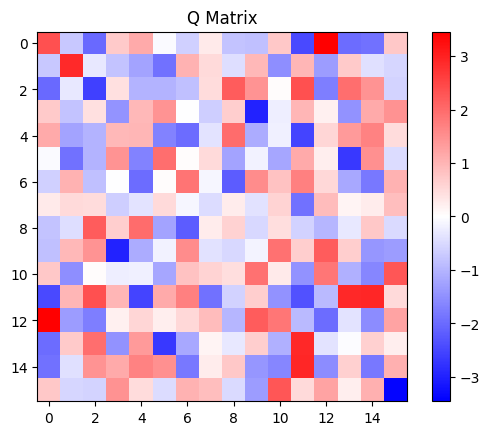

這個iter最小的FOM: 1.4232428550188174
第11次iteration


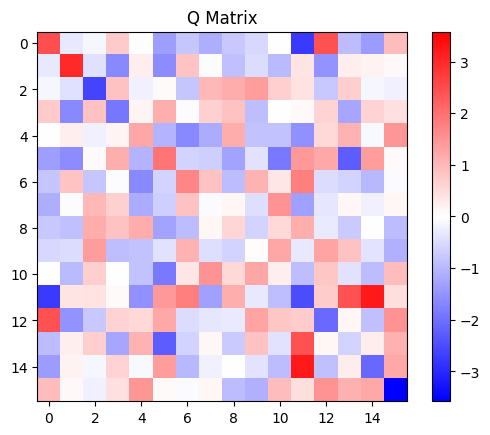

這個iter最小的FOM: 0.3723624570076557
第12次iteration


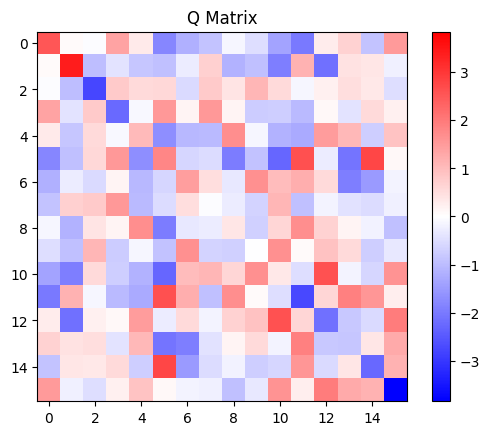

這個iter最小的FOM: 0.5935846166998848
第13次iteration


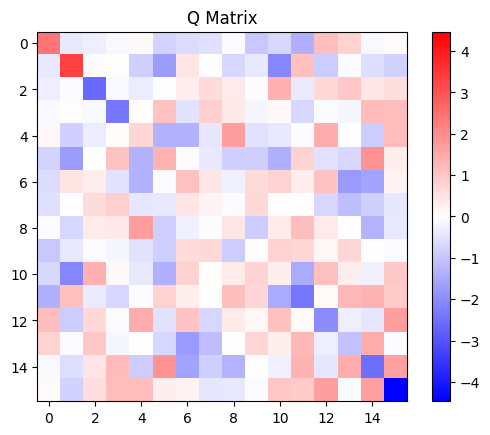

這個iter最小的FOM: 2.84268245845685
第14次iteration


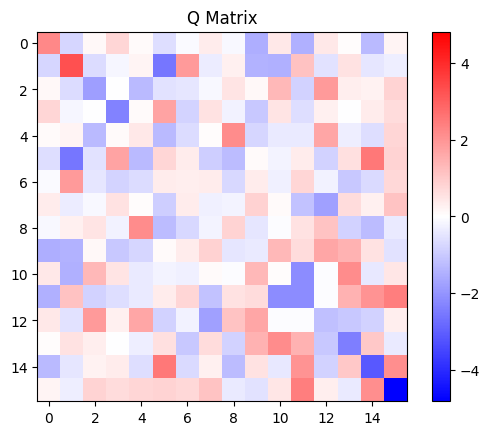

這個iter最小的FOM: 1.3229196291151442
第15次iteration


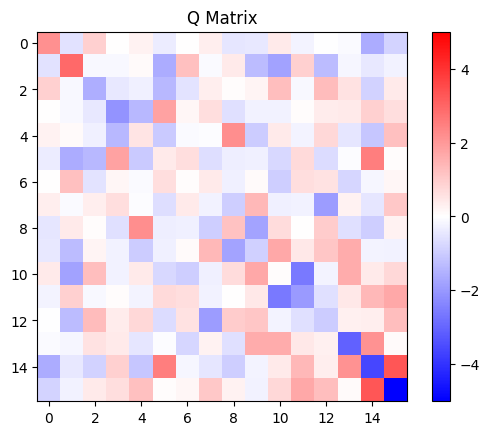

這個iter最小的FOM: 0.6679359420376441


In [32]:
actual_new_data = []    # 紀錄每次實際新增的數據筆數（用於畫FoM）

# 紀錄最小的FoM、第幾次iter得到最小FoM
min_fom = np.min(foms)
min_fom_iter = 0

for i in range(iteration):

    print(f"第{i+1}次iteration")

    # 定義檔名
    iter_model_path = os.path.join(iter_model_Q_path, f"{i+1}th_{iter_model_file_name}")
    iter_Q_arr_path = os.path.join(iter_model_Q_path, f"{i+1}th_{iter_Q_arr_file_name}")
    iter_Q_fig_path = os.path.join(iter_model_Q_path, f"{i+1}th_{iter_Q_fig_file_name}")

    # 訓練FM
    model.train(configs, foms, num_epoch=num_epoch, learning_rate=1.0e-2)
    model.save_model(path=iter_model_path)
    
    # 畫出Q Matrix
    model.plot_Q_matrix(show_fig=True, path_fig=iter_Q_fig_path, save_fig=True, path_data=iter_Q_arr_path, save_data=True)

    # 開始sampling
    sampleset = sampling(sampler_type=sampler_type, bqm=model.bqm())

    ## 挑選要新增的數據（第一步） - 使用FoM choosing
    sample_configs  = sampleset.record["sample"]
    sample_energies = sampleset.record["energy"]
    # 從num_reads個energies中，取前top_energy小的energies
    sorted_indices  = np.argsort(sample_energies)[:top_energy]
    sample_configs  = sample_configs[sorted_indices]
    sample_foms     = np.array([calc_fom(config, target) for config in sample_configs])
    # 從top_energy個energies中，取前top_fom小的foms
    sorted_indices = np.argsort(sample_foms)[:top_fom]
    sample_configs = sample_configs[sorted_indices]
    sample_foms    = sample_foms[sorted_indices]
    
    print(f"這個iter最小的FOM: {np.min(sample_foms)}")

    ## 挑選要新增的數據（第二步） - 不允許重複數據
    # 移除 sample_configs 中重複的 row，並同步刪除 sample_foms 對應元素
    unique_indices = np.unique(sample_configs, axis=0, return_index=True)[1]
    unique_indices = np.sort(unique_indices)
    sample_configs = sample_configs[unique_indices]
    sample_foms = sample_foms[unique_indices]
    # 移除 sample_configs 中出現在 configs 的 row，並同步刪除 sample_foms 對應元素
    mask = np.array([not np.any(np.all(configs == row, axis=1)) for row in sample_configs])
    sample_configs = sample_configs[mask]
    sample_foms = sample_foms[mask]

    ## 挑選要新增的數據（第三步） - 依照FoM由大到小排序
    sort_indices = np.argsort(sample_foms)[::-1]
    sample_configs = sample_configs[sort_indices]
    sample_foms = sample_foms[sort_indices]

    # 紀錄最小FoM、第幾次iter得到最小FoM
    if len(sample_foms) and (np.min(sample_foms) < min_fom):
        min_fom = np.min(sample_foms)
        min_fom_iter = i+1
    
    # 紀錄每次實際新增的數據筆數（用於畫FoM）
    if actual_new_data:
        actual_new_data.append(actual_new_data[-1] + sample_foms.shape[0])
    else:
        actual_new_data.append(sample_foms.shape[0])
    
    # 新增數據到dataset
    configs = np.r_[configs, sample_configs]
    foms = np.r_[foms, sample_foms]

    print("=" * 50)

# 儲存configs跟foms
np.save(configs_arr_path, configs)
np.save(foms_arr_path, foms)

# 儲存actual_new_data
actual_new_data = np.array(actual_new_data)
np.save(actual_new_data_path, actual_new_data)

# 創建資料夾紀錄最小FoM、第幾次iter找到最小FoM
min_fom_folder = f"第{min_fom_iter}次iter找到最小FoM:{min_fom}"
min_fom_path = os.path.join(base_path, min_fom_folder)
os.makedirs(min_fom_path)

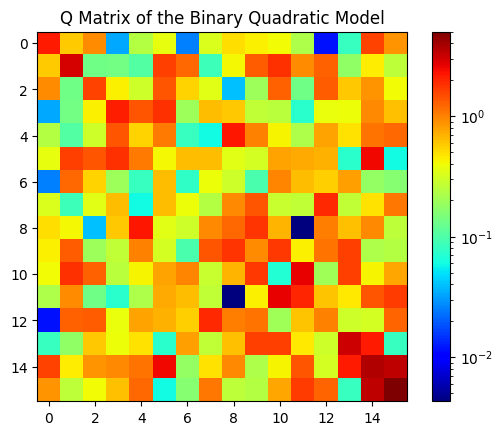

In [33]:
bqm = model.bqm()
# 取得變數列表
variables = list(bqm.variables)
num_variables = len(variables)

# 初始化Q Matrix
Q = np.zeros((num_variables, num_variables))

# 填充線性偏置（對角線元素）
for i, var in enumerate(variables):
    Q[i, i] = bqm.linear.get(var, 0)  # 使用 .get() 處理變數可能沒有線性偏置的情況

# 填充二次偏置（非對角線元素）
for (u, v), bias in bqm.quadratic.items():
    u_index = variables.index(u)
    v_index = variables.index(v)
    Q[u_index, v_index] = bias
    Q[v_index, u_index] = bias
    
# 找到 Q 矩陣的絕對值最大值，用於設定顏色範圍
max_abs_val = np.max(np.abs(Q))
from matplotlib.colors import LogNorm
# 畫圖
plt.figure()
plt.imshow(np.abs(Q), cmap='jet', norm=LogNorm(), interpolation='nearest')#, vmin=-max_abs_val, vmax=max_abs_val)
# plt.imshow(np.abs(Q)**0.5, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.xticks()
plt.yticks()
plt.title('Q Matrix of the Binary Quadratic Model')
plt.show()
# np.max(np.max(np.abs(Q)))
# np.min(np.abs(Q))

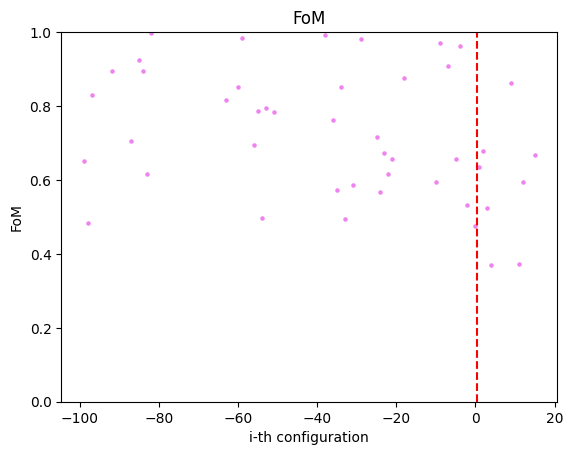

0.3695330718195605


In [34]:
## 畫一般的FoM圖（0之前包含0的是init_dataset；1之後包含1的是anneal新增的data）
x = np.linspace(1, foms.shape[0], foms.shape[0])
x -= init_dataset_size

plt.scatter(x, foms, label='foms', s=5, color="violet")  # s 控制點的大小，可調整

# 畫紅色垂直虛線 -> 之前的是init_dataset；之後的是anneal新增的data
plt.axvline(x=0.5, color='red', linestyle='--', label='x=0.5')
# # 畫灰色垂直虛線 -> 表示哪些數據是在同個iter
# for idx in actual_new_data:
#     plt.axvline(x=idx + 0.5, color='gray', linestyle='--', alpha=0.5)

plt.title("FoM")
plt.xlabel("i-th configuration")
plt.ylabel("FoM")
plt.ylim(0, 1)
plt.savefig(foms_fig_path, bbox_inches='tight', transparent=True)
plt.show()

# 印出最小FoM
print(np.min(foms))

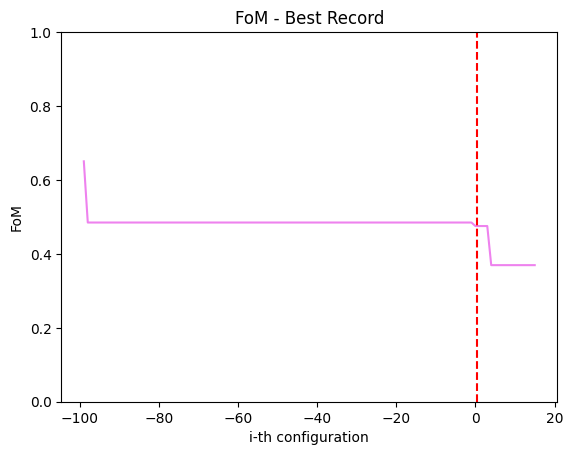

0.3695330718195605


In [35]:
## 畫最佳紀錄的FoM圖（0之前包含0的是init_dataset；1之後包含1的是anneal新增的data）
foms_best_record = [foms[0]]
for i in range(1,len(foms)):
    if foms[i] < foms_best_record[i-1]:    # 當前的FOM比之前的最佳紀錄還要小
        foms_best_record.append(foms[i])
    else:
        foms_best_record.append(foms_best_record[i-1])

x = np.linspace(1, foms.shape[0], foms.shape[0])
x -= init_dataset_size

plt.plot(x, foms_best_record, label="FoM - Best Record", color="violet")

# 畫紅色垂直虛線 -> 之前的是init_dataset；之後的是anneal新增的data
plt.axvline(x=0.5, color='red', linestyle='--', label='x=0.5')
# # 畫灰色垂直虛線 -> 表示哪些數據是在同個iter
# for idx in actual_new_data:
#     plt.axvline(x=idx + 0.5, color='gray', linestyle='--', alpha=0.5)

plt.title("FoM - Best Record")
plt.xlabel("i-th configuration")
plt.ylabel("FoM")
plt.ylim(0, 1)
plt.savefig(foms_fig_best_record_path, bbox_inches='tight', transparent=True)
plt.show()

# 印出最小FoM
print(np.min(foms))

## Problem Representation (by FMQA)
驗證FM(由FMQA訓練)能不能夠代表原始的物理問題

In [36]:
# 讀model
best_model_file_name = "3th_model.params"
best_model_path = os.path.join(iter_model_Q_path, best_model_file_name)
model = FactorizationMachine.load_model(var_num=rings, K=K, path=best_model_path)

In [37]:
sampleset = sampling(sampler_type="Exact", bqm=model.bqm(), num_reads=None)

# 取得所有組態、能量、FOMs
start_time = time.time()
sample_configs  = sampleset.record["sample"]
sample_energies = sampleset.record["energy"]
# sample_foms     = np.array([calc_fom(config, target) for config in sample_configs])
###############################~!@#$%^&*()_+#########################################
sample_foms = []
for i in range(len(sample_configs)):
    sample_config = sample_configs[i]
    query_idx = np.where((all_configs == sample_config).all(axis=1))[0][0]
    if query_idx.size:
        sample_foms.append(all_foms[query_idx])
    else:
        print("No query data")
        sys.exit(1)
sample_foms = np.array(sample_foms, dtype=np.float64)
#####################################################################################
end_time = time.time()
print(f"計算所有FOMs花了: {end_time - start_time} 秒")

# 讓energy由小排到大，其他變數跟著動
sorted_indices  = np.argsort(sample_energies)
sample_configs  = sample_configs[sorted_indices]
sample_energies = sample_energies[sorted_indices]
sample_foms     = sample_foms[sorted_indices]

計算所有FOMs花了: 145.9347324371338 秒


最小FoM的Index: 12570


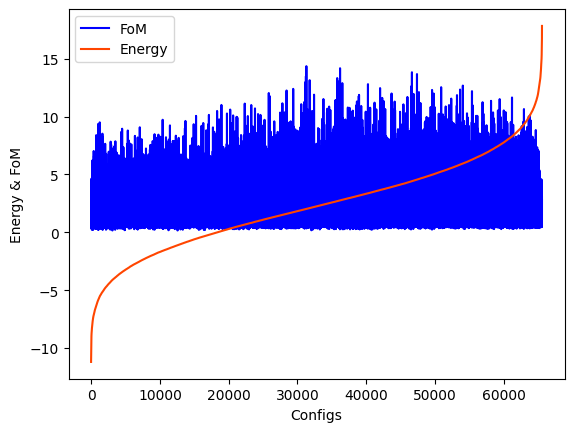

In [38]:
plt.plot(sample_foms, label="FoM", color="blue")
plt.plot(sample_energies, label="Energy", color="orangered")
plt.xlabel("Configs")
plt.ylabel("Energy & FoM")
plt.legend(facecolor='none')
plt.savefig(FM_path, bbox_inches='tight', transparent=True)

print(f"最小FoM的Index: {np.argmin(sample_foms)}")

In [39]:
# def find_indices(base, arr):
#     # 先確認 arr 的所有元素都存在於 base
#     if not np.all(np.isin(arr, base)):
#         raise ValueError("arr contains elements not found in base")

#     # 對 base 進行排序並記錄原始索引
#     sorted_idx = np.argsort(base)  # base 排序後的索引
#     sorted_base = base[sorted_idx]  # 排序後的 base

#     # 使用 searchsorted 找到 arr 在排序後 base 的索引
#     sorted_positions = np.searchsorted(sorted_base, arr)

#     # 轉換回原始 base 的索引
#     original_indices = sorted_idx[sorted_positions]

#     return original_indices

# if rings <= 16:    # rings太大不要用到Exact Solver
#     sampler_temp = dimod.ExactSolver()
#     sampleset_temp = sampler_temp.sample(model.bqm())
#     energy_temp = sampleset_temp.record["energy"]
#     ascending_indices = np.argsort(energy_temp)
#     energy_temp_sorted = energy_temp[ascending_indices]

#     arr = find_indices(energy_temp_sorted, energies) + 1
#     arr_str = ", ".join(map(str, arr))
#     print(f"new energies實際上是第幾小的: [{arr_str}]")
#     print(f"這些energies的值: [{', '.join(map(str, energies))}]")
#     print(f"這些energies對應的FOM: [{', '.join(map(str, foms))}]")
    
#     # 畫energy graph
#     sorted_energy_temp = np.sort(energy_temp)
#     plt.plot(sorted_energy_temp)
#     plt.xlabel("i-th configuration")
#     plt.ylabel("energy")
#     plt.xlim(0,300)
#     plt.ylim(-1,-.7)
#     plt.show()